In [1]:
username = "Alex"
pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")
path_to_save = "C:\\Users\\" *username *  "\\Desktop\\IJCNN\\"

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`

"C:\\Users\\Alex\\Desktop\\IJCNN\\"

In [2]:
using DynamicalSystems, DifferentialEquations

using Statistics
using StaticArrays
using CairoMakie
using JLD

In [3]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [4]:
function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,500000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,500000), pdf
end

CALCPDF (generic function with 1 method)

In [5]:
tspan = (0., 500000.)
a = 1.
b = 3.
c = 1.
d = 5.
xr = -1.6
r = 0.01
s = 5.
I = 4.
xv = 2.

k1= -0.17
k2 = k1

-0.17

In [6]:
cd("C:\\Users\\Alex\\YandexDisk\\Science\\HR\\1d maps\\1d map LSE k1=k2=-0.17")
matrix_condition = load("condition_matrix_k1k2_0.17.jld")["data"];
spectrum = load("spectrum_matrix_k1k2_0.17.jld")["data"];


k_space = range(0.0, 1.0, step = 0.0002)
length(k_space), length(spectrum[1, :])

(5001, 5001)

In [7]:
index = 775
k_space[index]

0.1548

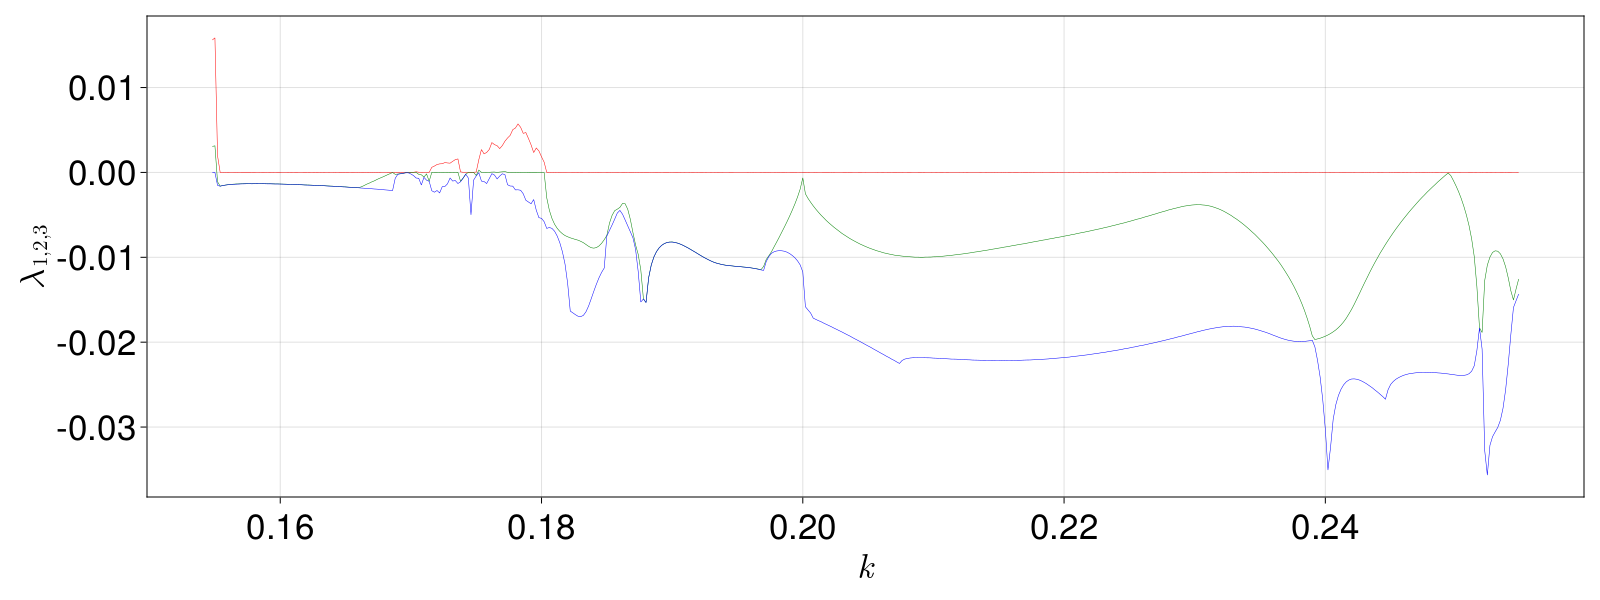

In [8]:
f = Figure(resolution = (1600, 600), fontsize = 35)

ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")

ts = index
tf = index + 500

lines!(ax, k_space[ts:tf], spectrum[1, ts:tf], color = "red", linewidth = 0.5)
lines!(ax, k_space[ts:tf], spectrum[2, ts:tf], color = "green", linewidth = 0.5)
lines!(ax, k_space[ts:tf], spectrum[3, ts:tf], color = "blue", linewidth = 0.5)

f

In [9]:
matrix_condition[:, index]

6-element Vector{Float64}:
 -1.3708880285256102
 -8.022011143224757
  4.3093369397057115
 -0.7483763647564559
 -1.8529391589460256
  4.142716799658893

In [10]:
spectrum[:, index]

6-element Vector{Float64}:
   0.015600802481299884
   0.003065302731414318
  -1.0880680523475515e-5
  -0.007165381408654947
  -5.791063602178957
 -11.880175305217701

In [11]:
condition_chaos = SA[    -1.3708880285256102,
 -8.022011143224757,
  4.3093369397057115,
 -0.7483763647564559,
 -1.8529391589460256,
  4.142716799658893]

6-element SVector{6, Float64} with indices SOneTo(6):
 -1.3708880285256102
 -8.022011143224757
  4.3093369397057115
 -0.7483763647564559
 -1.8529391589460256
  4.142716799658893

In [22]:
k = k_space[index]
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
 -0.17
  0.1548

In [23]:
prob = ODEProblem(HR, condition_chaos, tspan, p)

ODEProblem with uType SVector{6, Float64} and tType Float64. In-place: false
timespan: (0.0, 500000.0)
u0: 6-element SVector{6, Float64} with indices SOneTo(6):
 -1.3708880285256102
 -8.022011143224757
  4.3093369397057115
 -0.7483763647564559
 -1.8529391589460256
  4.142716799658893

In [24]:
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);

In [25]:
xsum = sol[1, :] + sol[4, :];
println("before: ", length(xsum))

xsum = xsum[floor(Int, length(xsum) / 4):end ]
println("after: ", length(xsum))

before: 6922111
after: 5191585


In [26]:
Hs1 = Hs(xsum, 6)

2.863621856800851

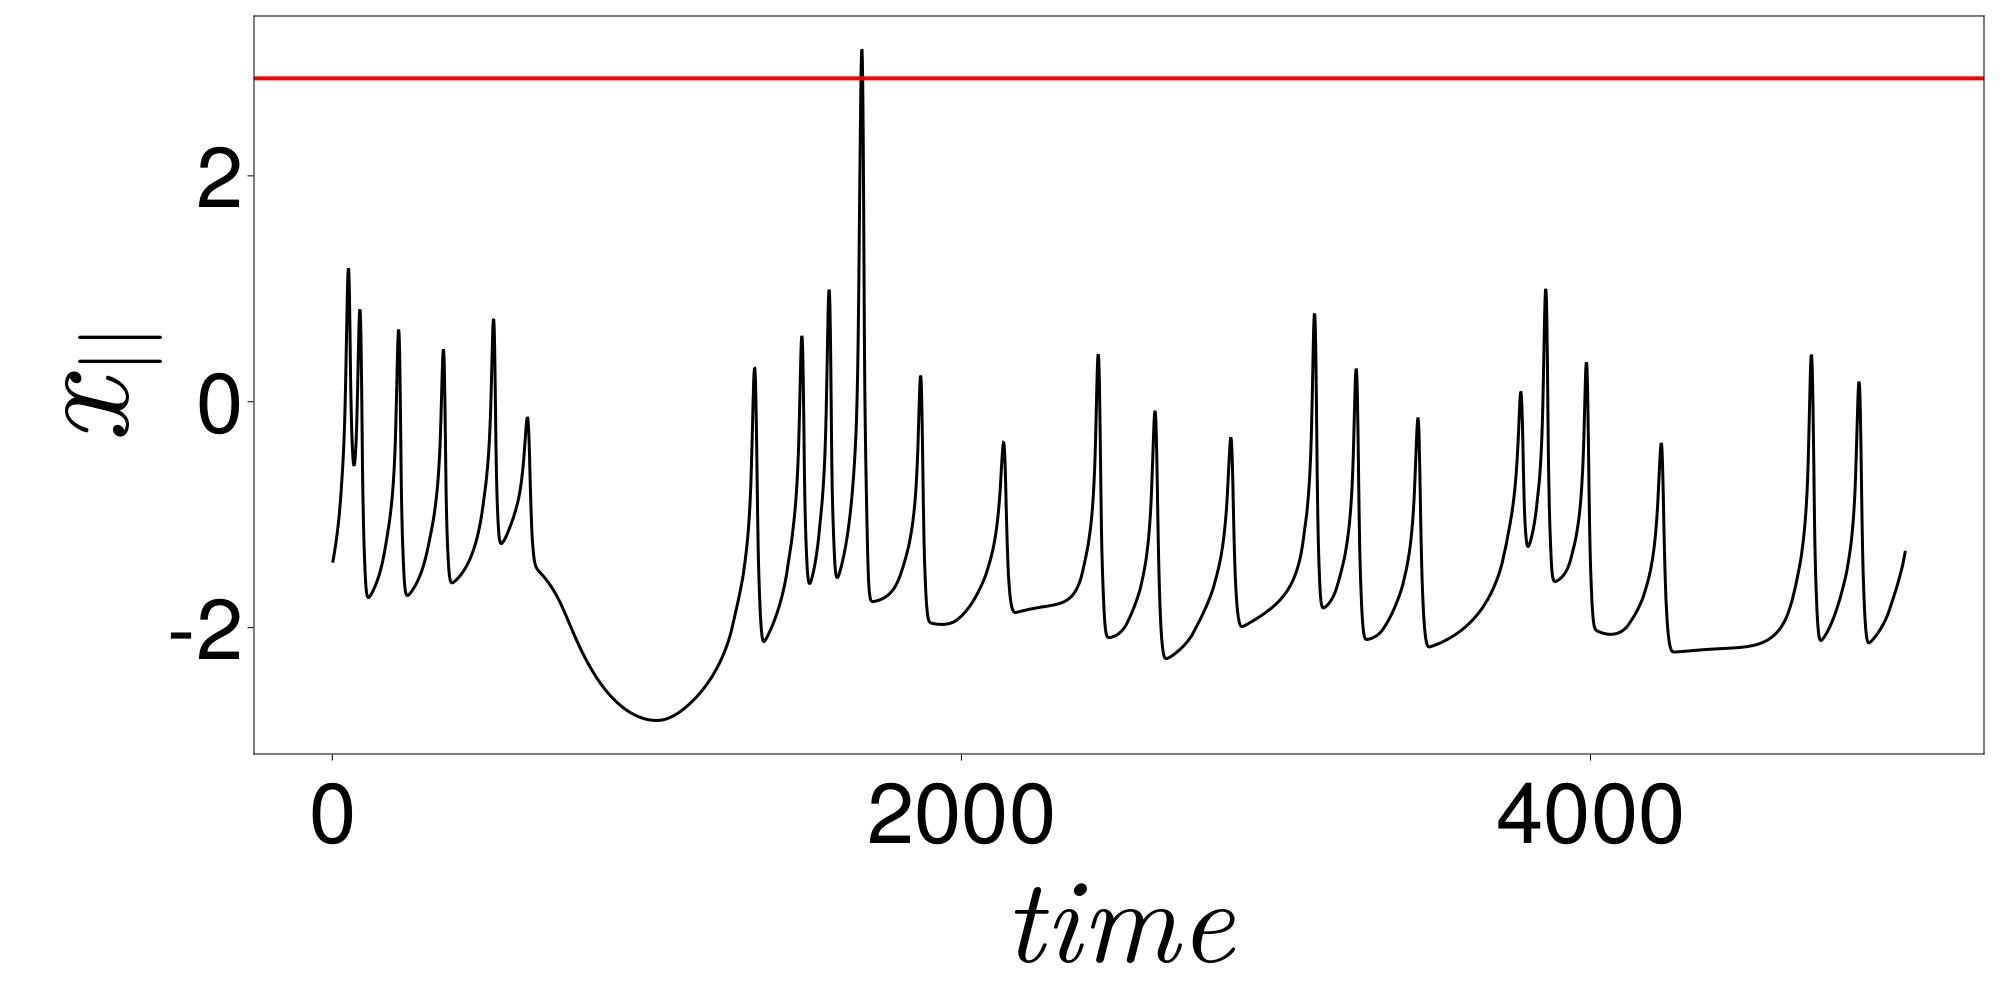

In [22]:
f = Figure(resolution = (2000, 1000))

ax = Axis(f[1, 1], xlabel = L"time", ylabel = L"x_{||}",
xlabelsize = 120, ylabelsize = 140,
                xticklabelsize = 85, yticklabelsize = 85)
ax.xgridvisible = false
ax.ygridvisible = false
lines!(ax, xsum[50000:55000], linewidth = 3.0, color = "black")
    
hlines!(Hs1, color = "red", linewidth = 4.0)


save("timesrieshyperchaos.eps", f)
f

In [112]:
sel_1, pdf_1 = CALCPDF(xsum)

(0.0:8.000016000032e-6:4.0, [0.03943901525256738, 0.03943882263316502, 0.039438437394360294, 0.0394374742973485, 0.0394365112003367, 0.03943631858093434, 0.03943631858093434, 0.03943612596153198, 0.03943516286452018, 0.03943535548392254  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [15]:
cd("C:\\Users\\Alex\\YandexDisk\\Science\\HR\\PDF")
sel_1 = load("sel_1_hyperch.jld")["data"]
pdf_1 = load("pdf_1_hyperch.jld")["data"];

In [16]:
EE_mapcopy = pdf_1;
EE_mapcopy = [ iszero(x) ? missing : x for x in EE_mapcopy ];

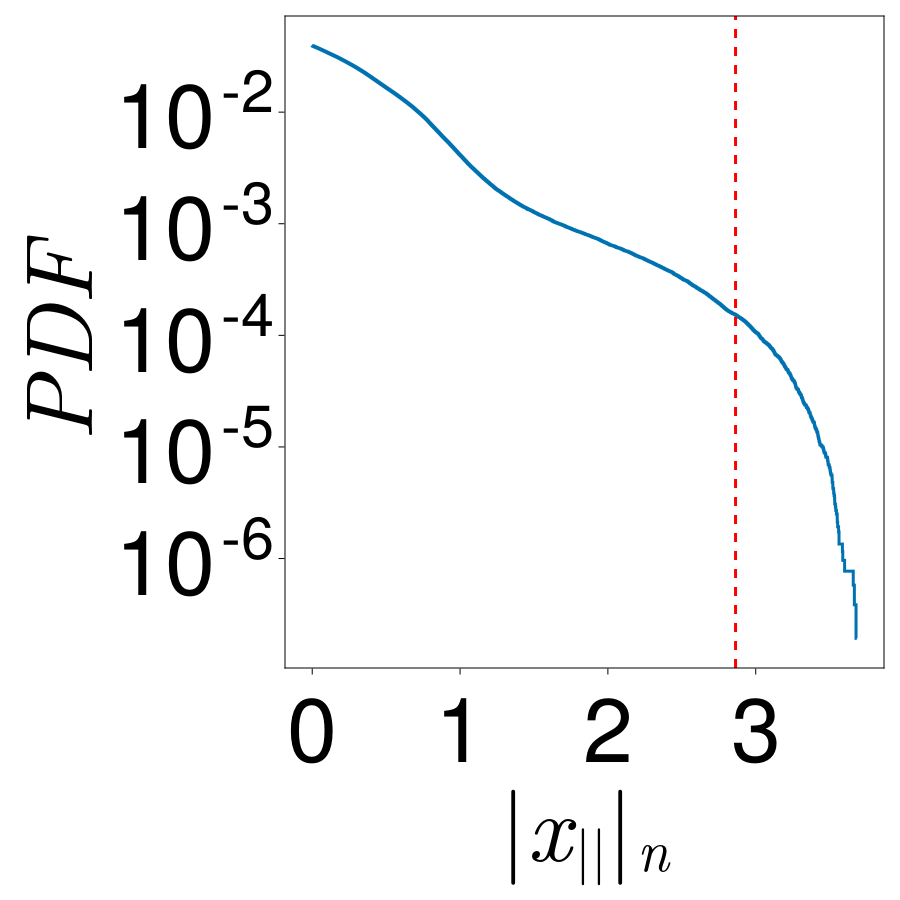

In [23]:
f = Figure(resolution = (900, 900))
ax = Axis(f[1, 1], yscale = log10,
xlabel = L"|x_{||}|_{n}", ylabel = L"PDF",
xlabelsize = 95, ylabelsize = 95,
                xticklabelsize = 90, yticklabelsize = 90)
ax.xgridvisible = false
ax.ygridvisible = false

lines!(sel_1, EE_mapcopy, linewidth = 3.0)
vlines!(ax, Hs1, color = "red", linestyle = :dash, linewidth = 3.0)
save("PDF_hyperchaos.eps", f)
f

In [18]:
labelsize = 50
ticksize = 40

40

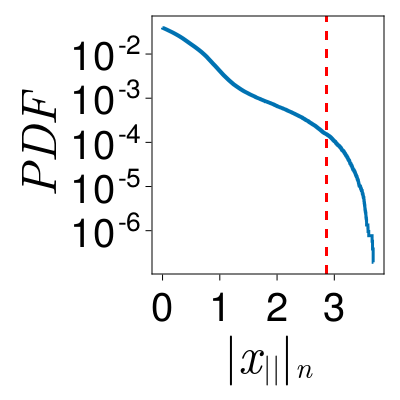

In [29]:
f = Figure(resolution = (400, 400))
ax = Axis(f[1, 1], yscale = log10,
            xlabel = L"|x_{||}|_{n}", ylabel = L"PDF",
            xlabelsize = labelsize, ylabelsize = labelsize,
            xticklabelsize = ticksize, yticklabelsize = ticksize, xgridvisible = false, ygridvisible = false)

lines!(sel_1, EE_mapcopy, linewidth = 3.0)
vlines!(ax, Hs1, color = "red", linestyle = :dash, linewidth = 3.0)

cd(path_to_save)
save("PDF_hyperchaos.pdf", f)
f

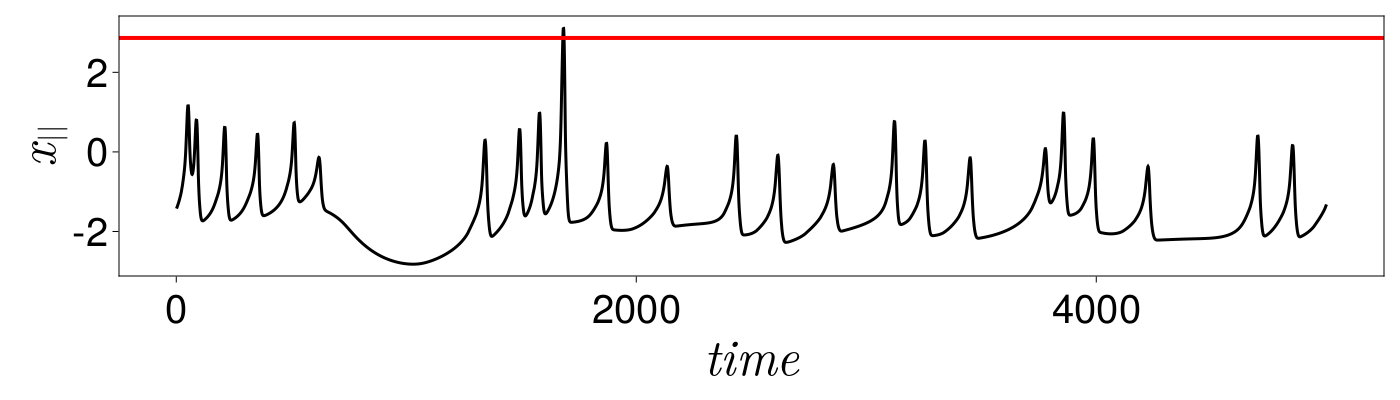

In [28]:
f = Figure(resolution = (1400, 400))

ax = Axis(f[1, 1], xlabel = L"time", ylabel = L"x_{||}",
            xlabelsize = labelsize, ylabelsize = labelsize,
            xticklabelsize = ticksize, yticklabelsize = ticksize)
                
ax.xgridvisible = false
ax.ygridvisible = false

lines!(ax, xsum[50000:55000], linewidth = 3.0, color = "black")
hlines!(Hs1, color = "red", linewidth = 4.0)



cd(path_to_save)
filename = "timesrieshyperchaos.pdf"
save(filename, f)
f